![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import re,string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import multiprocessing
from sklearn.model_selection import RepeatedKFold

In [3]:
# Carga de datos de archivo .csv
Train = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
Test = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
dataTraining = Train
dataTesting = Test

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [6]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


#### Preprocesamiento de Datos

In [7]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [8]:
dataTraining.isnull().sum()

year      0
title     0
plot      0
genres    0
rating    0
dtype: int64

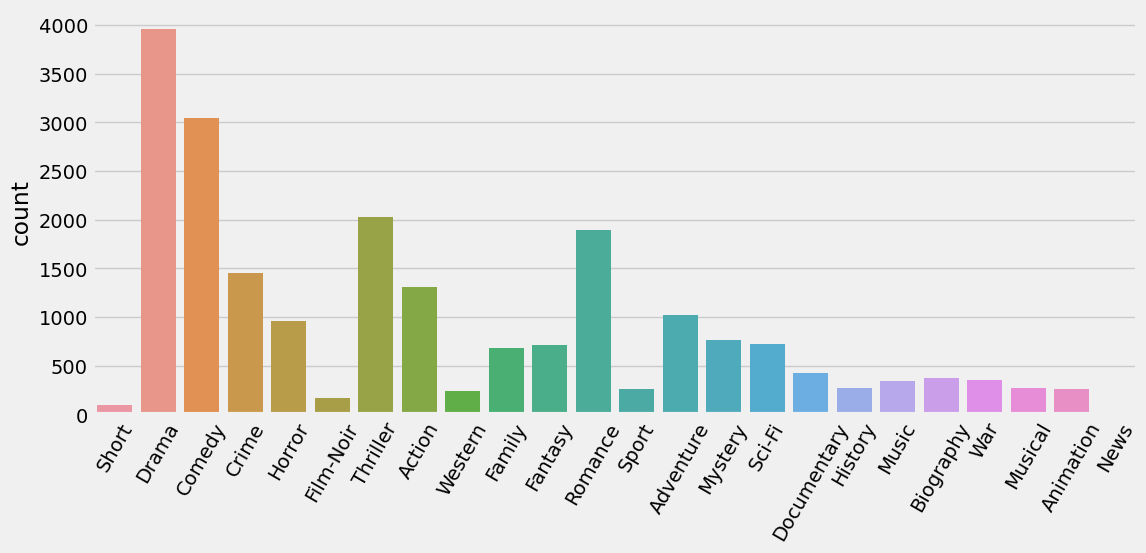

In [9]:
generos = []

for i in dataTraining['genres']:
    list_genres = ast.literal_eval(i)
    for j in list_genres:
        generos.append(j)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
sns.countplot(x=generos)    # Count of number of descriptions for each class label
plt.xticks(rotation=60)
plt.show()

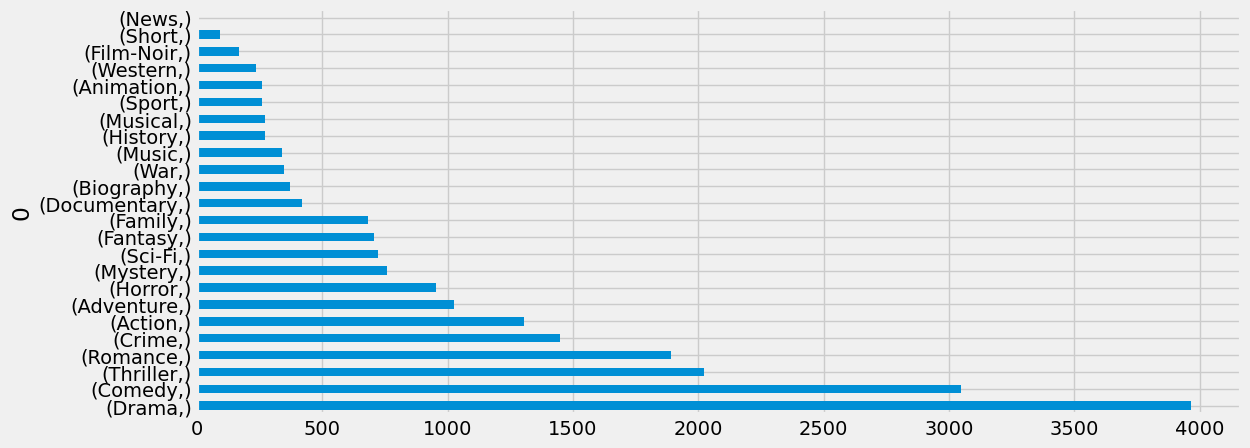

In [10]:
plt.figure(figsize=(12,5))
pd.DataFrame(generos).value_counts().plot.barh()
plt.show()

In [11]:
dataTraining['plot length']=dataTraining['plot'].apply(lambda x:len(x))   # calculating length of plot for each row
dataTraining.head()

,year,title,plot,genres,rating,plot length
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,1236
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,94
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,737
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,2067
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,1027


In [12]:
import re,string
import nltk
#nltk.download('stopwords')    # uncomment if stopwords are not downloaded
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

stemmer=LancasterStemmer()
stopwords=stopwords.words('english')

def clean_text(text):
    text=re.sub('-',' ',text.lower())   # replace `word-word` as `word word`
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stopwords]) # remove stopwords and stem other words
    text=re.sub(f'[{string.digits}]',' ',text)  # remove digits
    return re.sub(f'[{re.escape(string.punctuation)}]','',text) # remove punctuations

In [13]:
dataTraining['cleaned plot']=dataTraining['plot'].apply(clean_text)  # clean text for all rows of description
dataTesting['cleaned plot']=dataTesting['plot'].apply(clean_text)
dataTraining['cleaned plot length']=dataTraining['cleaned plot'].apply(lambda x:len(x))  # calculate length of cleaned text
dataTraining.head()

,year,title,plot,genres,rating,plot length,cleaned plot,cleaned plot length
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,1236,story singl fath tak eight year old son work r...,627
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,94,ser kil decid teach secret satisfy car video s...,56
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,737,swed fem blackmail disfig fac scar meet gentl...,382
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,2067,friday afternoon new york presid tredway corp...,1122
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,1027,los angel edit publ hous carol hunnicut goe b...,569


In [14]:
(dataTraining['cleaned plot length']>1500).value_counts()

False    7878
True       17
Name: cleaned plot length, dtype: int64

In [15]:
# Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(dataTraining))
filt=dataTraining['cleaned plot length']>1500
dataTraining.drop(dataTraining[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(dataTraining))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  7895
Dataframe size (after removal):  7878
Removed rows: 17


In [16]:
dataTraining.drop(columns=['title','plot','plot length','cleaned plot length'],axis=1,inplace=True)     # drop unnecessary columns for model
dataTesting.drop(columns=['title','plot'],axis=1,inplace=True)
dataTraining.head()

,year,genres,rating,cleaned plot
3107,2003,"['Short', 'Drama']",8.0,story singl fath tak eight year old son work r...
900,2008,"['Comedy', 'Crime', 'Horror']",5.6,ser kil decid teach secret satisfy car video s...
6724,1941,"['Drama', 'Film-Noir', 'Thriller']",7.2,swed fem blackmail disfig fac scar meet gentl...
4704,1954,['Drama'],7.4,friday afternoon new york presid tredway corp...
2582,1990,"['Action', 'Crime', 'Thriller']",6.6,los angel edit publ hous carol hunnicut goe b...


In [17]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1500, lowercase = False)
X_dtm = vect.fit_transform(dataTraining['cleaned plot'])
X_dtm.shape

(7878, 1500)

In [18]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [19]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [20]:
# # Grid de hiperparámetros evaluados
# # ==============================================================================
# param_grid = {'n_estimators'  : [50, 100, 500, 1000],
#               'max_features'  : ['auto', 'sqrt', 'log2'],
#               'max_depth'     : [None, 1, 3, 5, 10, 20],
#               'subsample'     : [0.5, 1],
#               'learning_rate' : [0.001, 0.01, 0.1]
#              }

# # Búsqueda por grid search con validación cruzada
# # ==============================================================================
# grid = GridSearchCV(
#         estimator  = xgb.XGBClassifier(random_state=123),
#         param_grid = param_grid,
#         scoring    = 'accuracy',
#         n_jobs     = multiprocessing.cpu_count() - 1,
#         cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
#         refit      = True,
#         verbose    = 0,
#         return_train_score = True
#        )

# grid.fit(X = X_train, y = y_train_genres)

# # Resultados
# # ==============================================================================
# resultados = pd.DataFrame(grid.cv_results_)
# resultados.filter(regex = '(param*|mean_t|std_t)') \
#     .drop(columns = 'params') \
#     .sort_values('mean_test_score', ascending = False) \
#     .head(4)

In [21]:
# # Mejores hiperparámetros por validación cruzada
# # ==============================================================================
# print("----------------------------------------")
# print("Mejores hiperparámetros encontrados (cv)")
# print("----------------------------------------")
# print(grid.best_params_, ":", grid.best_score_, grid.scoring)

In [22]:
# Definición y entrenamiento
clf = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...))

In [23]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8250640631415752

In [24]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['cleaned plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [25]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.003769,0.003974,0.000225,0.004729,0.283895,0.050655,0.002629,0.081329,0.001749,0.035708,...,0.003771,0.124610,0.000008,0.585874,0.014870,0.000191,0.001001,0.242171,0.000136,0.005936
4,0.046704,0.001535,0.000202,0.138806,0.197019,0.093167,0.117882,0.851953,0.001175,0.000323,...,0.005163,0.001410,0.000057,0.020042,0.002140,0.000776,0.001122,0.191015,0.001336,0.000518
5,0.021441,0.001163,0.000023,0.005646,0.082570,0.448941,0.000052,0.268767,0.000206,0.002436,...,0.000038,0.300133,0.008914,0.286078,0.368887,0.000013,0.000401,0.561183,0.000277,0.000186
6,0.017432,0.008728,0.000115,0.006362,0.297933,0.035311,0.000058,0.930315,0.000133,0.000741,...,0.002695,0.016774,0.000133,0.021591,0.003080,0.000007,0.000471,0.397187,0.004617,0.000820
7,0.020154,0.020091,0.000256,0.000392,0.417815,0.007357,0.000559,0.072334,0.004287,0.173313,...,0.003005,0.007341,0.000039,0.440303,0.999270,0.000239,0.000067,0.015344,0.048990,0.000809
